### Clustering with K-Means
In this notebook, we classify members based on their progressive scores from progressivepunch.com and govtrack.us.
They estimate how politically left or right a member is based on their views and voting on polarized ideologies.

The clustering algorithm is K-means, and the expected output should rank members as far left,  left-centrists, centrists, right-centrists, and far-right extremists.

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [8]:
!pip install statsmodels

In [9]:
# read dfs
# Joining the cleaned tweets with the handles to get progressive scores

twttr_df = pd.read_csv("handles_scores.csv")
clean_df = pd.read_csv("clean_tweets.csv")

In [10]:
clean_df.head(2)

,tweet_id,username,party,tweet,clean_text,favorite_count,retweet_count,created_at,source,social_policy,geopolitical_policy,policies,policy
0,1499070296338350081,boblatta,R,The PADE Act would ban the importation of Russ...,the pade act would ban the importation of russ...,3,0,2022-03-02 17:13:04+00:00,Twitter Web App,NaN,Geo Political Policies,"['Ukraine-Russia', '']",Ukraine-Russia
1,1503834686937837572,RepThompson,D,"Last week, I held a town hall with @USRepKCast...",last week held town hall with on the impact of...,14,4,2022-03-15 20:45:03+00:00,Hootsuite Inc.,Social Policies,NaN,"['Substance Abuse and Mental Health', 'Climate...",Climate Change


In [11]:
twttr_df.head(5)

,name,name_punch,name_gov,Twitter Handle,St/Dis,Party,progressive_score,state_tilt,rank,score
0,"Adams, Alma","Adams, Alma","Adams, Alma",RepAdams,NC12,D,96.91,Strong Dem,#372,0.22
1,"Aderholt, Robert","Aderholt, Robert","Aderholt, Robert",Robert_Aderholt,AL04,R,5.96,Strong Rep,#146,0.65
2,"Aguilar, Pete","Aguilar, Pete","Aguilar, Pete",RepPeteAguilar,CA31,D,92.43,Strong Dem,#296,0.30
3,"Allen, Rick","Allen, Rick","Allen, Rick",RepRickAllen,GA12,R,0.64,Strong Rep,#26,0.82
4,"Allred, Colin","Allred, Colin","Allred, Colin",RepColinAllred,TX32,D,95.00,Leans Dem,#217,0.44


In [12]:
# Joining the cleaned tweets with the handles to get progressive scores

df = clean_df.merge(
    twttr_df[
        [
            "Twitter Handle",
            "Party",
            "name_punch",
            "name_gov",
            "progressive_score",
            "state_tilt",
            "rank",
            "score",
        ]
    ],
    left_on=["username", "party"],
    right_on=["Twitter Handle", "Party"],
    how="left",
)
df.drop(["Twitter Handle", "Party"], axis=1, inplace=True)

df.head(3)

,tweet_id,username,party,tweet,clean_text,favorite_count,retweet_count,created_at,source,social_policy,geopolitical_policy,policies,policy,name_punch,name_gov,progressive_score,state_tilt,rank,score
0,1499070296338350081,boblatta,R,The PADE Act would ban the importation of Russ...,the pade act would ban the importation of russ...,3,0,2022-03-02 17:13:04+00:00,Twitter Web App,NaN,Geo Political Policies,"['Ukraine-Russia', '']",Ukraine-Russia,"Latta, Bob","Latta, Robert",1.56,Strong Rep,#45,0.77
1,1503834686937837572,RepThompson,D,"Last week, I held a town hall with @USRepKCast...",last week held town hall with on the impact of...,14,4,2022-03-15 20:45:03+00:00,Hootsuite Inc.,Social Policies,NaN,"['Substance Abuse and Mental Health', 'Climate...",Climate Change,"Thompson, Mike","Thompson, Mike",92.38,Strong Dem,#290,0.30
2,1574890109010411521,RepSwalwell,D,Rubio: Abortion is “manslaughter”\nLaxalt: Roe...,rubio abortion is manslaughter laxalt roe was ...,42440,13339,2022-09-27 22:33:56+00:00,Twitter for iPhone,Social Policies,NaN,"['Abortion', '']",Abortion,"Swalwell, Eric","Swalwell, Eric",94.87,Strong Dem,#301,0.30


## K-Means Clustering

In [13]:
from sklearn.cluster import KMeans

#### Clustering based on GovTrack scores

In [17]:
df_not_na = df[~(df.score.isna() | df.progressive_score.isna())]

# clustering based on govtrack scores
X1 = df_not_na[["score"]].iloc[:, :].values
inertia = []
for n in range(1, 11):
    algorithm = KMeans(
        n_clusters=n,
        tol=0.0001,
        random_state=111,
        algorithm="lloyd",
    )
    try:
        algorithm.fit(X1)
    except:
        pass
    inertia.append(algorithm.inertia_)

C:\Users\borki\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\borki\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\borki\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\borki\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value 

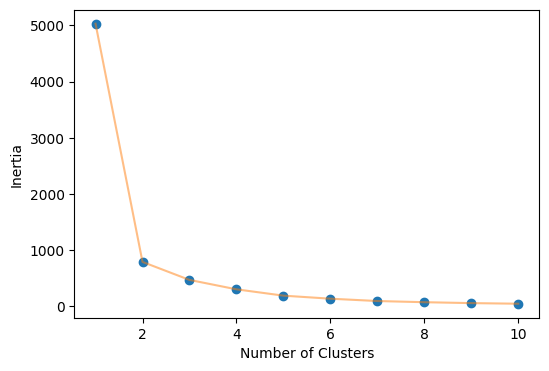

In [18]:
plt.figure(figsize=(6, 4))
plt.plot(np.arange(1, 11), inertia, "o")
plt.plot(np.arange(1, 11), inertia, "-", alpha=0.5)
plt.xlabel("Number of Clusters"), plt.ylabel("Inertia")
plt.show()

In [19]:
# initialize with 5 clusters

algorithm = KMeans(
    n_clusters=5,
    tol=0.0001,
    random_state=111,
    algorithm="lloyd",
)

algorithm.fit(X1)

C:\Users\borki\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=5, random_state=111)

In [22]:
# centroids of the clusters

centroids = algorithm.cluster_centers_
centroids

array([[0.83236866],
       [0.25676991],
       [0.39098105],
       [0.67916606],
       [0.11972604]])

In [23]:
# sort the labels based on centroid values e.g. lowest -> 0, highest -> 4
# this is useful in making the plots

# create a look up table
idx = np.argsort(algorithm.cluster_centers_.sum(axis=1))
lut = np.zeros_like(idx)

lut[idx] = np.arange(5)

In [24]:
# create a govtrack cluster category in the dataframe


df_not_na["govtrack_cluster"] = lut[algorithm.labels_]

C:\Users\borki\AppData\Local\Temp\ipykernel_5232\372910235.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_not_na["govtrack_cluster"] = lut[algorithm.labels_]


#### Cluster based on Progressivepunch scores

In [25]:
# clustering based on progressive scores scores
X1 = df_not_na[["progressive_score"]].iloc[:, :].values

# initialize with 5 clusters

algorithm = KMeans(
    n_clusters=5,
    tol=0.0001,
    random_state=111,
    algorithm="lloyd",
)

algorithm.fit(X1)

# sort the labels based on centroid values e.g. lowest -> 0, highest -> 4
# this is useful in making the plots

# create a look up table
idx = np.argsort(algorithm.cluster_centers_.sum(axis=1))
lut = np.zeros_like(idx)

lut[idx] = (np.arange(5))[::-1]

# create a govtrack cluster category in the dataframe

df_not_na["progressive_cluster"] = lut[algorithm.labels_]

C:\Users\borki\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\borki\AppData\Local\Temp\ipykernel_5232\3054659862.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_not_na["progressive_cluster"] = lut[algorithm.labels_]


In [26]:
# create labels from gov_track categories

# cluster labels
labels = np.arange(5)
label_names = ["Far Right", "Right Centrist", "Centrist", "Left Centrist", "Far Left"][
    ::-1
]

df_not_na["govtrack_class"] = df_not_na.govtrack_cluster.apply(
    lambda x: (dict(map(lambda i, j: (i, j), labels, label_names)))[x]
)

C:\Users\borki\AppData\Local\Temp\ipykernel_5232\1960629483.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_not_na["govtrack_class"] = df_not_na.govtrack_cluster.apply(


In [27]:
df_not_na.to_csv("tweets_scores.csv", index=False)